In [1]:
from path import Path
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from matplotlib import pyplot as plt
import numpy as np
from sqlalchemy import create_engine

## Import Data from Database

In [2]:
#change room occupancy count to occupancy in Data 1

con = create_engine("sqlite:///sensor-telemetry.sqlite")

kukuroo_df = pd.read_sql('select * from kukuroo', con)
ananth_df = pd.read_sql('select * from ananth', con)

## Create function to perform Random Forest Analysis

In [3]:
ananth_df.columns

Index(['index', 'S1_Temp', 'S2_Temp', 'S3_Temp', 'S4_Temp', 'S1_Light',
       'S2_Light', 'S3_Light', 'S4_Light', 'S1_Sound', 'S2_Sound', 'S3_Sound',
       'S4_Sound', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR', 'Occupancy',
       'timestamp'],
      dtype='object')

In [4]:
kukuroo_df.columns

Index(['index', 'Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio',
       'Occupancy', 'timestamp'],
      dtype='object')

In [5]:
ananth_df_light=ananth_df.drop(["S1_Temp", "S2_Temp", "S3_Temp", "S4_Temp", "S1_Sound", "S2_Sound", "S3_Sound",
       "S4_Sound", "S5_CO2", "S5_CO2_Slope", "S6_PIR", "S7_PIR"], axis=1)

In [6]:
kukuroo_df_light=kukuroo_df.drop(["Temperature", "Humidity", "Light", "CO2", "HumidityRatio"], axis=1)

In [7]:
# Create Function to Automate Random Forest Model

def occupancy_forest(df):
    
    # Remove Timestamp from Dataset
    df_clean = df.drop("timestamp", axis=1)
    
    # Define Features Set
    X = df_clean.copy()
    X = X.drop("Occupancy", axis=1)
    
    # Define the Target Vector
    y = df_clean["Occupancy"].values.ravel()
    
    # Splitting into Train and Test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)
    
    # Creating StandardScaler instance
    scaler = StandardScaler()
    
    # Fitting Standard Scaller
    X_scaler = scaler.fit(X_train)
    
    # Scaling data
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    # Creating the decision tree classifier instance
    rf_model = RandomForestClassifier(n_estimators=128, random_state=78)
    
    # Fitting the model
    rf_model = rf_model.fit(X_train_scaled, y_train)
    
    # Making predictions using the testing data
    predictions = rf_model.predict(X_test_scaled)
    
    # Calculating the confusion matrix
    cm = confusion_matrix(y_test, predictions)
    cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])
    
    # Calculating the accuracy score
    acc_score = accuracy_score(y_test, predictions)
    
    # Displaying results
    print("Confusion Matrix")
    display(cm_df)
    print(f"Accuracy Score : {acc_score}")
    print("Classification Report")
    print(classification_report(y_test, predictions))
    
    # Determine rf_model feature importances
    feature_names = X.columns
    importances = rf_model.feature_importances_
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances.sort_values(ascending=False,inplace=True)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,3928,19
Actual 1,17,1176


Accuracy Score : 0.9929961089494164
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3947
           1       0.98      0.99      0.98      1193

    accuracy                           0.99      5140
   macro avg       0.99      0.99      0.99      5140
weighted avg       0.99      0.99      0.99      5140



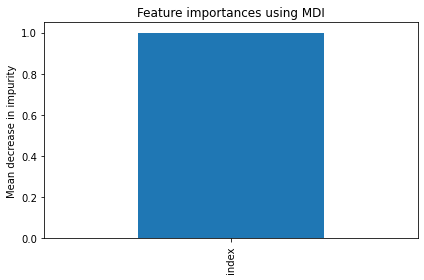

In [8]:
occupancy_forest(kukuroo_df_light)

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,2023,0
Actual 1,2,508


Accuracy Score : 0.9992104224240032
Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2023
           1       1.00      1.00      1.00       510

    accuracy                           1.00      2533
   macro avg       1.00      1.00      1.00      2533
weighted avg       1.00      1.00      1.00      2533



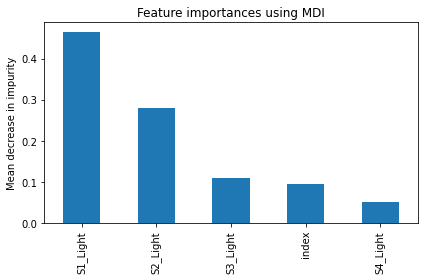

In [9]:
occupancy_forest(ananth_df_light)